#Setup

In [1]:
!pip install PyPortfolioOpt
!pip install python-binance

     |████████████████████████████████| 61 kB 3.1 MB/s 
     |████████████████████████████████| 2.8 MB 9.8 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 10.7 MB/s 
     |████████████████████████████████| 112 kB 58.5 MB/s 
     |████████████████████████████████| 288 kB 49.5 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 47.4 MB/s 
     |████████████████████████████████| 144 kB 31.1 MB/s 


In [43]:
from binance import Client
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
client = Client()

#Functions Def

In [30]:
#Get Historical Klines from Binance
def getdailydata(symbol):
  frame = pd.DataFrame(client.get_historical_klines(symbol,'1d', '3 years ago UTC'))        #Pull /Symbol: BTC-USDT / Interval: 1 Day / Period: 3 Years
  frame = frame[[0,4]]                                                                      #[Timestamp, Close Time]
  frame.columns = ['Timestamp', symbol]                                                     
  frame = frame.set_index('Timestamp')
  frame = frame.astype(float)
  return frame

In [31]:
symbols = ['BTCUSDT','ETHUSDT','BNBUSDT','XRPUSDT','ADAUSDT']

In [32]:
price = []
for symbol in symbols:
  price.append(getdailydata(symbol))

In [33]:
df = pd.concat(price, axis=1)
df

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
Timestamp,,,,,
1556841600000,5772.69,168.06,23.6999,0.30784,0.06995
1556928000000,5829.45,163.70,22.8888,0.30305,0.06687
1557014400000,5775.62,163.05,22.9777,0.30044,0.06603
1557100800000,5747.79,173.00,22.1895,0.30283,0.06696
1557187200000,5846.34,169.18,20.6602,0.29819,0.06412
...,...,...,...,...,...
1651104000000,39742.07,2936.93,407.1000,0.64280,0.84320
1651190400000,38596.11,2817.13,393.0000,0.61160,0.80480
1651276800000,37630.80,2726.66,377.1000,0.58450,0.75560


In [34]:
mu = expected_returns.mean_historical_return(df, frequency=365)                           #Mu: Mean of the historical return (Average over 3y)
mu

BTCUSDT    0.883805
ETHUSDT    1.554827
BNBUSDT    1.536569
XRPUSDT    0.257406
ADAUSDT    1.230081
dtype: float64

In [35]:
S = risk_models.sample_cov(df, frequency=365)                                             #Sigma: Volatility (Covariance)
S

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
BTCUSDT,0.580711,0.590720,0.549393,0.523937,0.556017
ETHUSDT,0.590720,0.922292,0.728741,0.723012,0.789330
BNBUSDT,0.549393,0.728741,1.241502,0.712871,0.754582
XRPUSDT,0.523937,0.723012,0.712871,1.477508,0.795160
ADAUSDT,0.556017,0.789330,0.754582,0.795160,1.274988


In [36]:
ef = EfficientFrontier (mu, S)                                                            #Efficient Frontier

#PLOT

In [45]:
ef.tickers                                                                              #Pulling the tickers from Efficient Frotier

['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

In [46]:
ef.expected_returns                                                                     #Pulling the expected return from the assets

array([0.88380527, 1.55482674, 1.53656883, 0.25740579, 1.23008125])

In [47]:
np.diag(ef.cov_matrix) ** (1/2)                                                         #Pulling the volatilty of the assets (square root of diagonal of cavariance matrix)

array([0.76204421, 0.96036018, 1.11422703, 1.21552793, 1.12915359])

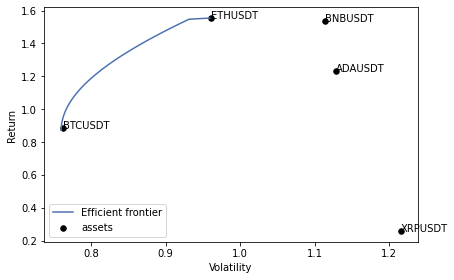

In [48]:
ef = EfficientFrontier (mu, S)                                                          #before run the plot, run again fx EfficientFrotier or an error will show up

fig, ax = plt.subplots()                                                                #Function to merge Plot with tickers
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
for i, txt in enumerate(ef.tickers):
    ax.annotate(txt, ((np.diag(ef.cov_matrix) ** (1/2))[i], ef.expected_returns[i]))

#RESULTS

In [60]:
ef = EfficientFrontier (mu, S)                                                          #before run the plot, run again fx EfficientFrotier or an error will show up
weights = ef.max_sharpe()                                                               #Retur % of Asset to invest to Max Portfolio
weights

OrderedDict([('BTCUSDT', 0.0),
             ('ETHUSDT', 0.7406576095577623),
             ('BNBUSDT', 0.2593423904422377),
             ('XRPUSDT', 0.0),
             ('ADAUSDT', 0.0)])

In [61]:
ef.portfolio_performance(verbose=True)                                                  #Return the portfolio performance

Expected annual return: 155.0%
Annual volatility: 93.2%
Sharpe Ratio: 1.64


(1.5500916920587895, 0.9324190360175715, 1.6409914780310801)

In [64]:
ef = EfficientFrontier (mu, S)
weights = ef.min_volatility()                                                           #Retur % of Asset to invest to Min Volatility
weights

OrderedDict([('BTCUSDT', 0.9190092571680643),
             ('ETHUSDT', 0.0),
             ('BNBUSDT', 0.0266826211502568),
             ('XRPUSDT', 0.048747985619048),
             ('ADAUSDT', 0.0055601360626311)])